# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import pytorch_lightning as pl
import torch 

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
PyTorch Lightning -> {pl.__version__}
Torch -> {torch.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
PyTorch Lightning -> 1.6.1
Torch -> 1.11.0



In [3]:
###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [45]:
path = Path('../../datasets/Ch13/')
# Read the daily_weather.csv 
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

daily_weather.ffill(inplace=True)

## Tranform the data sets
### Windowing

In [46]:
def one_step_sliding_window(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [47]:
sliding_window = 5
air_d = one_step_sliding_window(air, sliding_window)
dw_d = one_step_sliding_window(daily_weather, sliding_window)
en_d = one_step_sliding_window(energy, sliding_window)

### Scale and split data

In [7]:
class Standardize:
    def __init__(self, df, split=0.15):
        self.data = df
        self.split = split
    
    def _split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit(self):
        train, test, val = self._split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [8]:
scale_air = Standardize(air_d)
scale_dw = Standardize(dw_d)
scale_en = Standardize(en_d)

train_air, test_air, val_air = scale_air.fit()
train_dw, test_dw, val_dw = scale_dw.fit()
train_en, test_en, val_en = scale_en.fit()

In [9]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 102 , test: 20, val:17



### Split into X and Y (Features and Target)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [49]:
def features_target(*args):
    y = [torch.from_numpy(col.pop('y').values).float() for col in args]
    x = [torch.from_numpy(col.values).float()
                   for col in args]
    return *y, *x

In [50]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air, 
                               val_air, 
                               test_air)

(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw, 
                             val_dw, 
                             test_dw)

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en, 
                             val_en, 
                             test_en)

KeyError: 'y'

# RNN/LSTM in PyTorch

In [14]:
# convert numpy array to torch tensor
x_train_air = torch.from_numpy(x_train_air.reshape(-1, x_train_air.shape[1])).float()
y_train_air = torch.from_numpy(y_train_air).float()
x_test_air = torch.from_numpy(x_test_air.reshape(-1, x_test_air.shape[1])).float()
y_test_air = torch.from_numpy(y_test_air).float()

In [15]:
# convert numpy array to torch tensor
x_train_dw = torch.from_numpy(x_train_dw.reshape(-1, x_train_air.shape[1])).float()
y_train_dw = torch.from_numpy(y_train_dw).float()
x_test_dw = torch.from_numpy(x_test_dw.reshape(-1, x_test_air.shape[1])).float()
y_test_dw = torch.from_numpy(y_test_dw).float()

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=5, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x.shape = torch.Size([102, 5])
        # x.shape = torch.Size([102, 5, 1])
        x, _ = self.lstm(x)
        # x.shape = torch.Size([102, 5, 5])
        x = self.fc(x)
        # x.shape = torch.Size([102, 5])
        return x

    def init_hidden(self, batch_size):
        return (torch.zeros(5, batch_size, self.hidden_size),
                torch.zeros(5, batch_size, self.hidden_size))

In [22]:
def train(x_train, y_train, epochs=1000):
    input_size = x_train.shape[1]
    hidden_size = 5
    output_size = 1
    
    model = LSTM(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = []

    for epoch in range(epochs):
        # initialize hidden state
        hidden = model.init_hidden(x_train.shape[0])
        # detach hidden state from its history
        # so we don't backpropagate through the entire history
        # convert numpy array to torch tensor
        # forward pass
        y_pred = model(x_train)
        # compute loss
        loss = criterion(y_pred, y_train)
        history.append(loss)
        # zero gradients
        optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return history, y_pred, model

In [23]:
history_air, y_pred_air, model_air = train(x_train_air, y_train_air)

Epoch [50/1000], Loss: 1.0252
Epoch [100/1000], Loss: 1.0000
Epoch [150/1000], Loss: 0.6524
Epoch [200/1000], Loss: 0.3856
Epoch [250/1000], Loss: 0.3263
Epoch [300/1000], Loss: 0.2861
Epoch [350/1000], Loss: 0.2793
Epoch [400/1000], Loss: 0.2427
Epoch [450/1000], Loss: 0.2369
Epoch [500/1000], Loss: 0.2076
Epoch [550/1000], Loss: 0.1905
Epoch [600/1000], Loss: 0.2192
Epoch [650/1000], Loss: 0.2413
Epoch [700/1000], Loss: 0.1961
Epoch [750/1000], Loss: 0.2052
Epoch [800/1000], Loss: 0.1899
Epoch [850/1000], Loss: 0.1982
Epoch [900/1000], Loss: 0.1996
Epoch [950/1000], Loss: 0.1913
Epoch [1000/1000], Loss: 0.1844


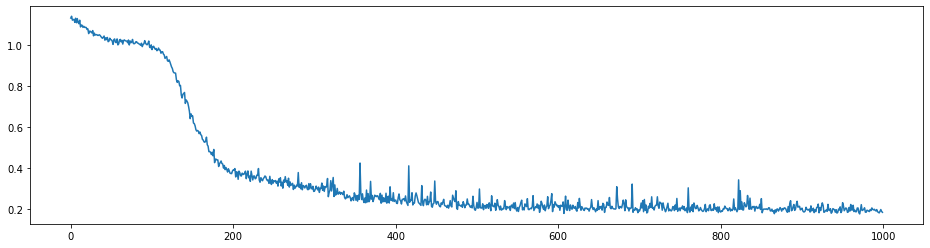

In [37]:
plt.plot([i.detach().numpy() for i in history_air])

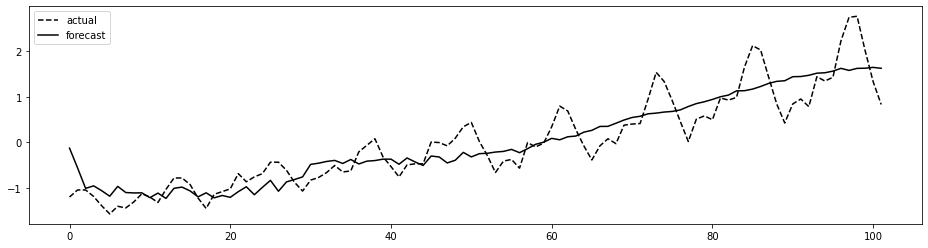

In [25]:
plt.plot(y_train_air, 'k--', label='actual')
plt.plot(y_pred_air.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [27]:
y_hat_air = model_air(x_test_air)
# evaluate on y_test
mse = nn.MSELoss()
mse_loss_air = mse(y_hat, y_test_air)
print(f'MSE Loss: {mse_loss_air.item():.4f}')

MSE Loss: 7.2235


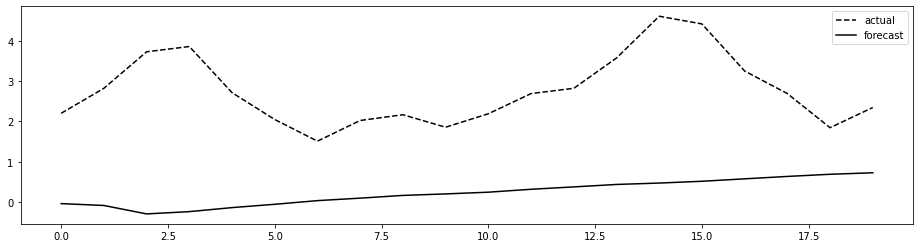

In [29]:
plt.plot(y_test_air, 'k--', label='actual')
plt.plot(y_hat_air.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [38]:
def train_batch(x_train, y_train, epochs=1000, batch_size=32):
    input_size = x_train.shape[1]
    hidden_size = 5
    output_size = 1
    
    model = LSTM(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = []

    for epoch in range(epochs):
        # initialize hidden state
        hidden = model.init_hidden(batch_size)
        # detach hidden state from its history
        # so we don't backpropagate through the entire history
        # convert numpy array to torch tensor
        # forward pass
        y_pred = model(x_train)
        # compute loss
        loss = criterion(y_pred, y_train)
        history.append(loss)
        # zero gradients
        optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return history, y_pred, model

In [39]:
history_dw, y_pred_dw, model_dw = train_batch(x_train_dw, y_train_dw, epochs=500, batch_size=64)

Epoch [50/500], Loss: 1.0145
Epoch [100/500], Loss: 0.9937
Epoch [150/500], Loss: 0.8245
Epoch [200/500], Loss: 0.7879
Epoch [250/500], Loss: 0.7861
Epoch [300/500], Loss: 0.7767
Epoch [350/500], Loss: 0.7789
Epoch [400/500], Loss: 0.7816
Epoch [450/500], Loss: 0.7842
Epoch [500/500], Loss: 0.7785


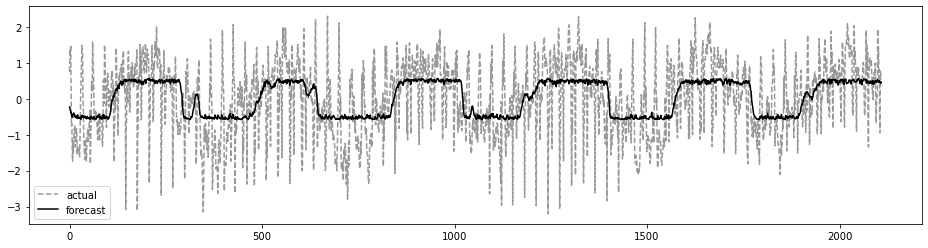

In [43]:
plt.plot(y_train_dw, 'k--', label='actual', alpha=0.40)
plt.plot(y_pred_dw.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [41]:
y_hat_dw = model_dw(x_test_dw)
# evaluate on y_test
mse = nn.MSELoss()
mse_loss_dw = mse(y_hat_dw, y_test_dw)
print(f'MSE Loss: {mse_loss_dw.item():.4f}')

MSE Loss: nan


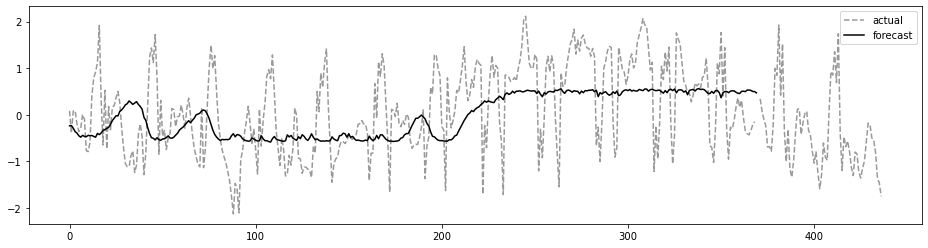

In [44]:
plt.plot(y_test_dw, 'k--', label='actual', alpha=0.40)
plt.plot(y_hat_dw.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [ ]:
history_en, y_pred_en, model_en = train_batch(x_train_en, y_train_en, epochs=500, batch_size=64)

In [ ]:
plt.plot(y_train_en, 'k--', label='actual', alpha=0.40)
plt.plot(y_pred_en.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [ ]:
y_hat_en = model_en(x_test_en)
# evaluate on y_test
mse = nn.MSELoss()
mse_loss_en = mse(y_hat_en, y_test_en)
print(f'MSE Loss: {mse_loss_en.item():.4f}')